In [2]:
import pandas as pd
import numpy as np

# 1 - prev_Arr_delay (vip)
# 2 - Scheduledd Gap (derived)
# 3 - Net buffer (derived)
# 4 - Propagated_Rist (created)
# 5 - Actual Ground Window (created)
# 6 - Flight Sequence (derived)
# 7 - Origin Health (created)
# 3 created and 3 derived featues

# --- 1. SETUP ---
df = pd.read_csv('jan_2025_sanitized.csv')
def to_mins(t):
    if pd.isna(t) or t == '': return 0
    t = int(float(t))
    return (t // 100) * 60 + (t % 100)

# --- 2. ROTATION PHYSICS (MTT = 71 per your findings) ---
df = df.sort_values(['Tail_Number', 'FlightDate', 'CRSDepTime']).reset_index(drop=True)
df['Prev_Arr_Delay'] = df.groupby(['Tail_Number', 'FlightDate'])['ArrDelayMinutes'].shift(1).fillna(0)

# Time Math
df['DepMins'] = df['CRSDepTime'].apply(to_mins)
prev_arr_m = df.groupby(['Tail_Number', 'FlightDate'])['CRSArrTime'].shift(1).apply(to_mins)

df['Scheduled_Gap'] = df['DepMins'] - prev_arr_m
df.loc[df['Scheduled_Gap'] < -1000, 'Scheduled_Gap'] += 1440 

# Core Physics Features
MTT = 45
df['Net_Buffer'] = df['Scheduled_Gap'] - MTT
df['Propagated_Risk'] = (df['Prev_Arr_Delay'] - df['Net_Buffer']).clip(lower=0)
df['Actual_Ground_Window'] = df['Scheduled_Gap'] - df['Prev_Arr_Delay']
df['Flight_Sequence'] = df.groupby(['Tail_Number', 'FlightDate']).cumcount() + 1

# --- 3. SYSTEMIC CONTEXT ---
df['DepHour'] = (df['CRSDepTime'] // 100).astype(int)

# Origin Health (Real-time)
df = df.sort_values(['Origin', 'FlightDate', 'CRSDepTime'])
df['Origin_Health'] = df.groupby(['Origin', 'FlightDate'])['DepDel15'].transform(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
).fillna(0)


# --- 4. STRATEGIC CONTEXT (Hub Status) ---
hub_map = df.groupby(['Reporting_Airline', 'Origin']).size().reset_index(name='Volume')
threshold = hub_map['Volume'].quantile(0.8)
df = df.merge(hub_map, on=['Reporting_Airline', 'Origin'], how='left')

# --- 5. FINAL EXPORT ---
df_final = df.drop(columns=['ArrDelayMinutes']).copy()
print(f"Final Feature Set Ready. Using MTT={MTT} based on Correlation Optimization.")

Final Feature Set Ready. Using MTT=45 based on Correlation Optimization.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import time
import pandas as pd

# 1. DEFINE FINAL PREDICTOR LIST
# These 10 features are chosen for physical defensibility and high correlation
features = [
    'Prev_Arr_Delay',         # Physical Input (Leg n-1) #basic
    'Net_Buffer',             # Operational Slack (using MTT 71) #basic
    'Propagated_Risk',        # Mathematical Spillover   #basic
    'Actual_Ground_Window',   # Real-time Turnaround Room  #zhou
    'Flight_Sequence',        # Cumulative Fatigue  #flights on a airport
    'DepHour',                # Temporal Block #original
    'Origin_Health'           # Real-time Airport Load  #airport load
]
cat_features = ['Reporting_Airline', 'Origin', 'Dest']

X = df_final[features + cat_features].copy()
y = df_final['DepDel15'].astype(int)

# 2. DATA SPLIT & PREPARATION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encoder for Random Forest (requires numeric inputs)
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()
for col in cat_features:
    le = LabelEncoder()
    X_train_rf[col] = le.fit_transform(X_train_rf[col].astype(str))
    X_test_rf[col] = le.transform(X_test_rf[col].astype(str))

# Set Category type for Boosters
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 3. THE BATTLE OF THE ALGORITHMS
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, enable_categorical=True, tree_method="hist"),
    "LightGBM": lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.05, cat_features=cat_features, verbose=0)
}

results = []
trained_models = {}

print("Starting Model Competition...")
for name, model in models.items():
    start = time.time()
    
    if name == "Random Forest":
        model.fit(X_train_rf, y_train)
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, probs)
    elapsed = time.time() - start
    
    results.append({"Model": name, "ROC-AUC": round(auc, 4), "Train Time (s)": round(elapsed, 2)})
    trained_models[name] = model # Store for feature importance later

# 4. LEADERBOARD
comparison_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\n" + "="*40)
print("FINAL MODEL LEADERBOARD (MTT=71)")
print("="*40)
print(comparison_df.to_string(index=False))

Starting Model Competition...

FINAL MODEL LEADERBOARD (MTT=71)
        Model  ROC-AUC  Train Time (s)
     CatBoost   0.8593          154.86
     LightGBM   0.8590           10.50
      XGBoost   0.8576           13.65
Random Forest   0.8508           18.46



UPDATED LEADERBOARD WITH BRIER SCORES:
        Model  ROC-AUC  Train Time (s)  Brier Score
     CatBoost   0.8593          154.86       0.0818
     LightGBM   0.8590           10.50       0.0818
      XGBoost   0.8576           13.65       0.0821
Random Forest   0.8508           18.46       0.0835

Brier Scores calculated and Reliability Diagram saved.


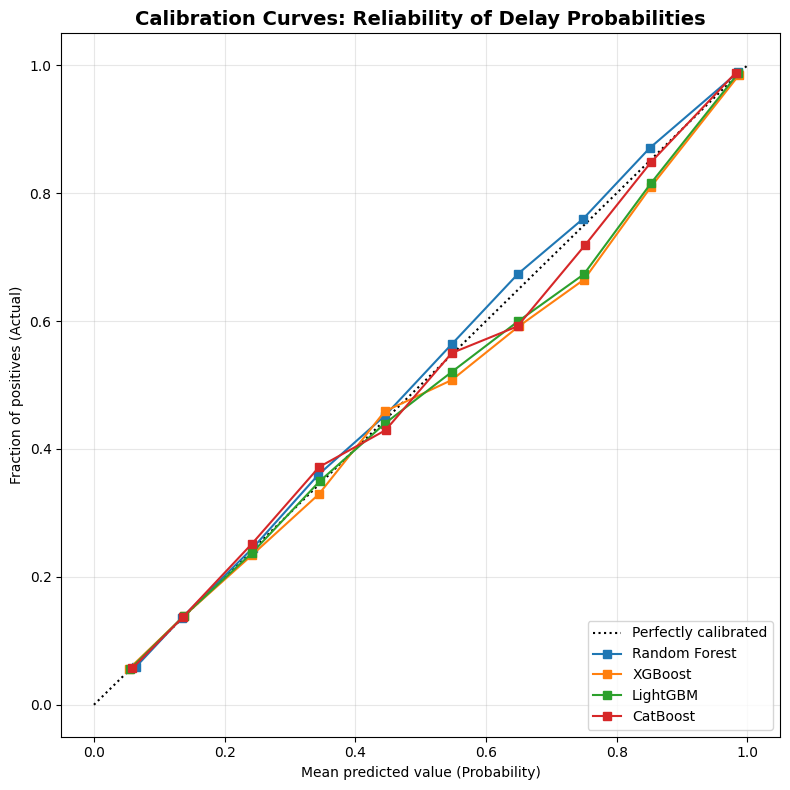

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# 1. CALCULATE BRIER SCORES
brier_results = []

for name, model in models.items():
    if name == "Random Forest":
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        probs = model.predict_proba(X_test)[:, 1]
    
    score = brier_score_loss(y_test, probs)
    brier_results.append({"Model": name, "Brier Score": round(score, 4)})

# Add to your existing comparison dataframe
brier_df = pd.DataFrame(brier_results)
final_comparison = comparison_df.merge(brier_df, on="Model")
print("\nUPDATED LEADERBOARD WITH BRIER SCORES:")
print(final_comparison.to_string(index=False))

# 2. GENERATE CALIBRATION CURVE (RELIABILITY DIAGRAM)
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name, model in models.items():
    if name == "Random Forest":
        probs = model.predict_proba(X_test_rf)[:, 1]
    else:
        probs = model.predict_proba(X_test)[:, 1]
    
    # Get calibration curve data
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.ylabel("Fraction of positives (Actual)")
plt.xlabel("Mean predicted value (Probability)")
plt.title("Calibration Curves: Reliability of Delay Probabilities", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_reliability_curve.png', dpi=300)

print("\nBrier Scores calculated and Reliability Diagram saved.")

Dual performance graph saved.


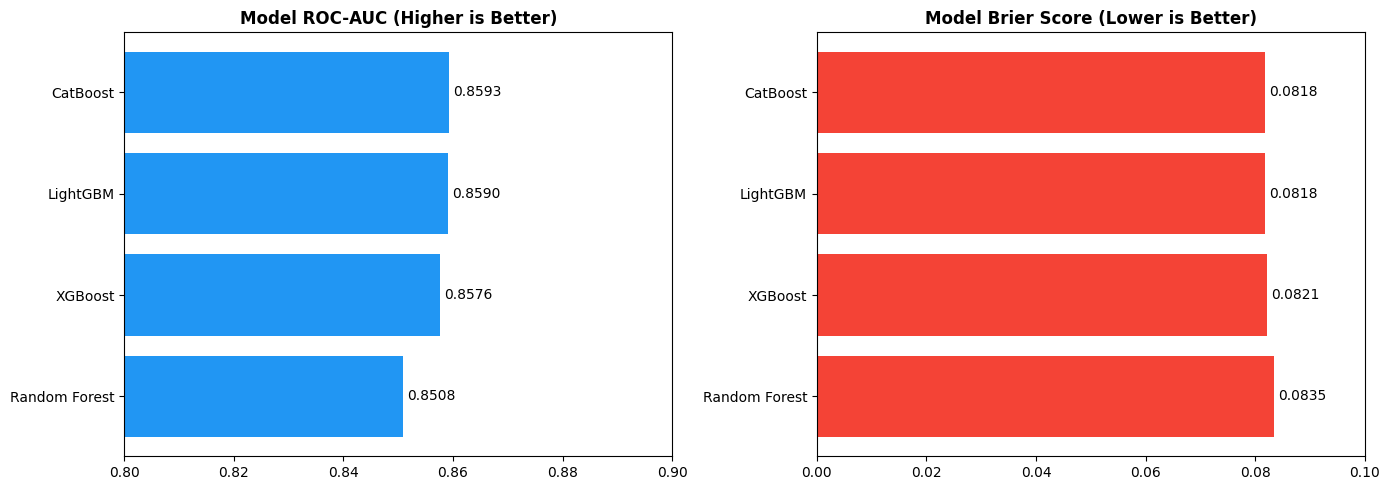

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your latest run
data = {
    'Model': ['CatBoost', 'LightGBM', 'XGBoost', 'Random Forest'],
    'AUC': [0.8593, 0.8590, 0.8576, 0.8508],
    'Brier': [0.0818, 0.0818, 0.0821, 0.0835]
}
res_df = pd.DataFrame(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot AUC
bars1 = ax1.barh(res_df['Model'], res_df['AUC'], color='#2196F3')
ax1.set_title('Model ROC-AUC (Higher is Better)', fontweight='bold')
ax1.set_xlim(0.8, 0.9)
ax1.invert_yaxis()
ax1.bar_label(bars1, padding=3, fmt='%.4f')

# Plot Brier Score
bars2 = ax2.barh(res_df['Model'], res_df['Brier'], color='#F44336')
ax2.set_title('Model Brier Score (Lower is Better)', fontweight='bold')
ax2.set_xlim(0, 0.1)
ax2.invert_yaxis()
ax2.bar_label(bars2, padding=3, fmt='%.4f')

plt.tight_layout()
plt.savefig('performance_metrics_dual.png', dpi=300)
print("Dual performance graph saved.")

C:\Users\parij\AppData\Local\Temp\ipykernel_24756\2173302095.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importances, palette='mako')


Feature importance graph saved as 'feature_importance_lightgbm.png'


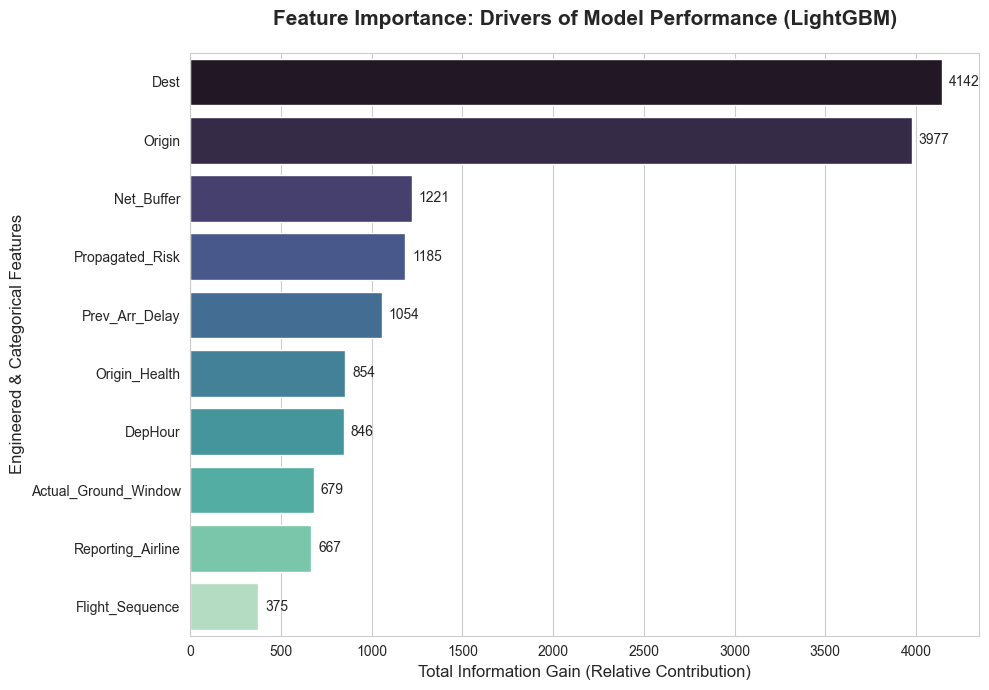

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract importance from the trained LightGBM model
lgbm_model = trained_models["LightGBM"]
# 'gain' is usually better for research as it shows the total contribution to the model's accuracy
importance_type = 'gain' 
importances = pd.DataFrame({
    'Feature': features + cat_features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

# 2. Plotting
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Use a professional color palette
ax = sns.barplot(x='Importance', y='Feature', data=importances, palette='mako')

# Add labels to the bars for clarity
for i in ax.containers:
    ax.bar_label(i, padding=5, fmt='%.0f', fontsize=10)

plt.title('Feature Importance: Drivers of Model Performance (LightGBM)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Total Information Gain (Relative Contribution)', fontsize=12)
plt.ylabel('Engineered & Categorical Features', fontsize=12)

# Clean up the look
plt.tight_layout()
plt.savefig('feature_importance_lightgbm.png', dpi=300)
print("Feature importance graph saved as 'feature_importance_lightgbm.png'")

In [7]:
import pandas as pd

# 1. Get the feature importance from the trained LightGBM model
# 'gain' is the best measure here as it shows how much each feature 
# contributed to the model's accuracy (reduction of loss)
importance_values = lgbm_model.feature_importance(importance_type='gain')
feature_names = features + cat_features

# 2. Create the table
importance_table = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance Score': importance_values
})

# 3. Calculate the Percentage Share to prove the "equal distribution"
total_gain = importance_table['Importance Score'].sum()
importance_table['Predictor Share (%)'] = (importance_table['Importance Score'] / total_gain) * 100

# 4. Sort and Format
importance_table = importance_table.sort_values(by='Predictor Share (%)', ascending=False).reset_index(drop=True)

# Rounding to 2 decimals for a cleaner look in the paper
importance_table['Predictor Share (%)'] = importance_table['Predictor Share (%)'].round(2)
importance_table['Importance Score'] = importance_table['Importance Score'].round(0)

print("--- FEATURE IMPORTANCE TABLE ---")
print(importance_table)

# Export for your paper
importance_table.to_csv('feature_importance_table.csv', index=False)

AttributeError: 'LGBMClassifier' object has no attribute 'feature_importance'

In [8]:
import pandas as pd

# 1. Get the feature importance from the trained LGBMClassifier
# The sklearn wrapper uses .feature_importances_ 
importance_values = lgbm_model.feature_importances_
feature_names = features + cat_features

# 2. Create the table
importance_table = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance Score': importance_values
})

# 3. Calculate the Percentage Share
total_importance = importance_table['Importance Score'].sum()
importance_table['Predictor Share (%)'] = (importance_table['Importance Score'] / total_importance) * 100

# 4. Sort and Format
importance_table = importance_table.sort_values(by='Predictor Share (%)', ascending=False).reset_index(drop=True)

# Rounding for the research paper
importance_table['Predictor Share (%)'] = importance_table['Predictor Share (%)'].round(2)

print("--- FEATURE IMPORTANCE TABLE ---")
print(importance_table)

# Export for your paper
importance_table.to_csv('feature_importance_table.csv', index=False)

--- FEATURE IMPORTANCE TABLE ---
           Feature Name  Importance Score  Predictor Share (%)
0                  Dest              4142                27.61
1                Origin              3977                26.51
2            Net_Buffer              1221                 8.14
3       Propagated_Risk              1185                 7.90
4        Prev_Arr_Delay              1054                 7.03
5         Origin_Health               854                 5.69
6               DepHour               846                 5.64
7  Actual_Ground_Window               679                 4.53
8     Reporting_Airline               667                 4.45
9       Flight_Sequence               375                 2.50


In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Prepare data for Boosters (LightGBM, CatBoost, XGBoost)
X_test_booster = X_test.copy()
for col in cat_features:
    X_test_booster[col] = X_test_booster[col].astype('category')

# 2. Prepare data for Logistic Regression (Encoding + Scaling)
X_test_encoded = X_test.copy()
le = LabelEncoder()
for col in cat_features:
    # We use fit_transform here just to ensure the mapping exists for the plot, 
    # though in a real pipeline you'd use the training encoder.
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_encoded)

# 3. Collect predictions
results_dict = {
    "LightGBM": lgbm_model.predict_proba(X_test_booster)[:, 1],
    "CatBoost": cat_model.predict_proba(X_test_booster)[:, 1],
    "XGBoost":  xgb_model.predict_proba(X_test_booster)[:, 1],
    "Logistic Regression": lr_model.predict_proba(X_test_scaled)[:, 1]
}

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# --- ROC Competition ---
ax1.plot([0, 1], [0, 1], color='black', linestyle='--', label='Naive Baseline (AUC = 0.50)')
for (name, probs), color in zip(results_dict.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax1.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')
ax1.set_title('ROC Competition: Performance vs. Baseline', fontsize=14, fontweight='bold')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# --- PR Curve ---
baseline_pr = np.mean(y_test)
ax2.axhline(y=baseline_pr, color='black', linestyle='--', label=f'Random Guess (Prec = {baseline_pr:.2f})')
for (name, probs), color in zip(results_dict.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ax2.plot(recall, precision, color=color, lw=2, label=name)
ax2.set_title('PR Curve: Precision vs. Operational Recall', fontsize=14, fontweight='bold')
ax2.set_xlabel('Recall (Delays Caught)')
ax2.set_ylabel('Precision (Reliability)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

NameError: name 'cat_model' is not defined

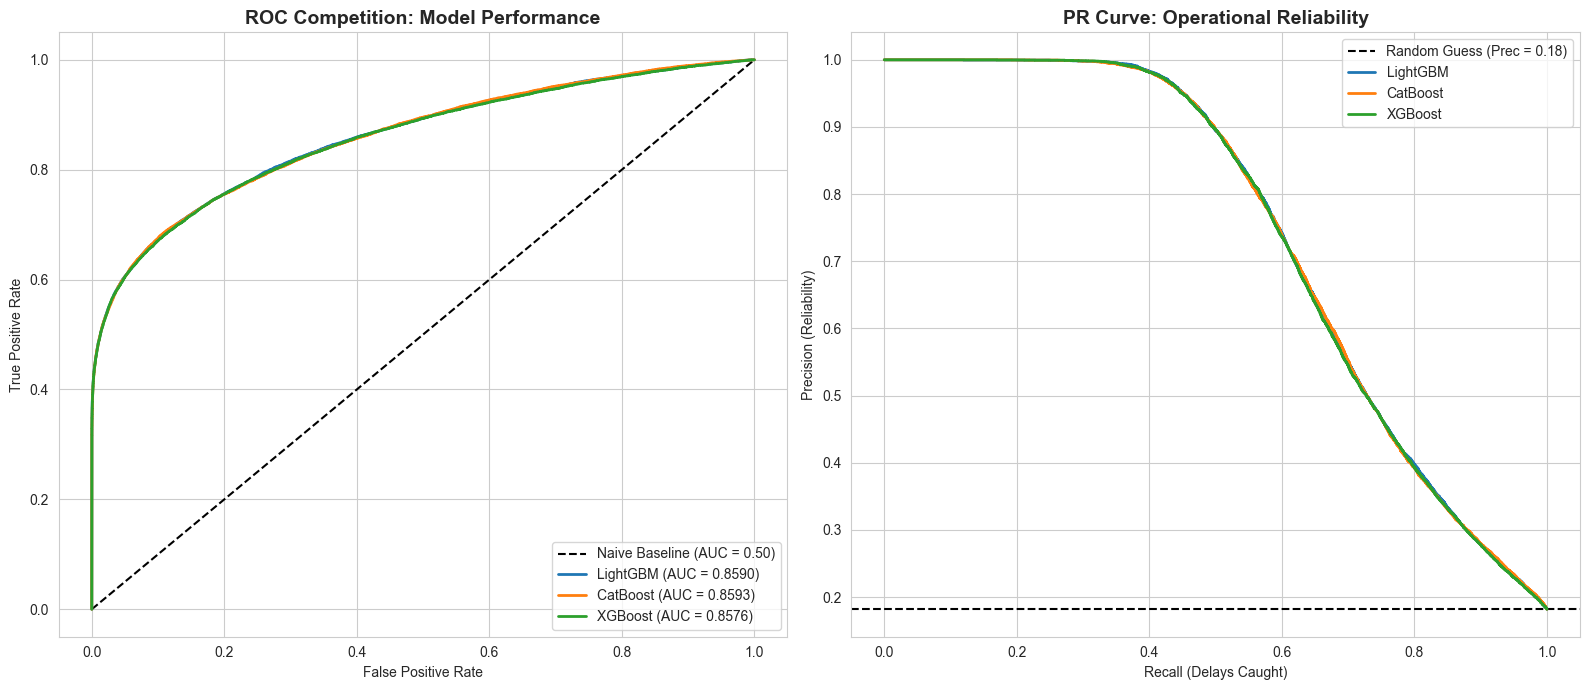

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np

# 1. Define the test sets properly
X_test_booster = X_test.copy()
for col in cat_features:
    X_test_booster[col] = X_test_booster[col].astype('category')

X_test_encoded = X_test.copy()
from sklearn.preprocessing import LabelEncoder, StandardScaler
for col in cat_features:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))
X_test_scaled = StandardScaler().fit_transform(X_test_encoded)

# 2. Extract models from your 'trained_models' dictionary
# Adjusting names to match what you likely have in your dictionary
results_dict = {}
if "LightGBM" in trained_models:
    results_dict["LightGBM"] = trained_models["LightGBM"].predict_proba(X_test_booster)[:, 1]
if "CatBoost" in trained_models:
    results_dict["CatBoost"] = trained_models["CatBoost"].predict_proba(X_test_booster)[:, 1]
if "XGBoost" in trained_models:
    results_dict["XGBoost"] = trained_models["XGBoost"].predict_proba(X_test_booster)[:, 1]

# We need the Logistic Regression object - assuming it was stored as 'lr' or in the dict
if "Logistic Regression" in trained_models:
    results_dict["Logistic Regression"] = trained_models["Logistic Regression"].predict_proba(X_test_scaled)[:, 1]

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# ROC Curve
ax1.plot([0, 1], [0, 1], color='black', linestyle='--', label='Naive Baseline (AUC = 0.50)')
for (name, probs), color in zip(results_dict.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax1.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')
ax1.set_title('ROC Competition: Model Performance', fontsize=14, fontweight='bold')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# PR Curve
baseline_pr = np.mean(y_test)
ax2.axhline(y=baseline_pr, color='black', linestyle='--', label=f'Random Guess (Prec = {baseline_pr:.2f})')
for (name, probs), color in zip(results_dict.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ax2.plot(recall, precision, color=color, lw=2, label=name)
ax2.set_title('PR Curve: Operational Reliability', fontsize=14, fontweight='bold')
ax2.set_xlabel('Recall (Delays Caught)')
ax2.set_ylabel('Precision (Reliability)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

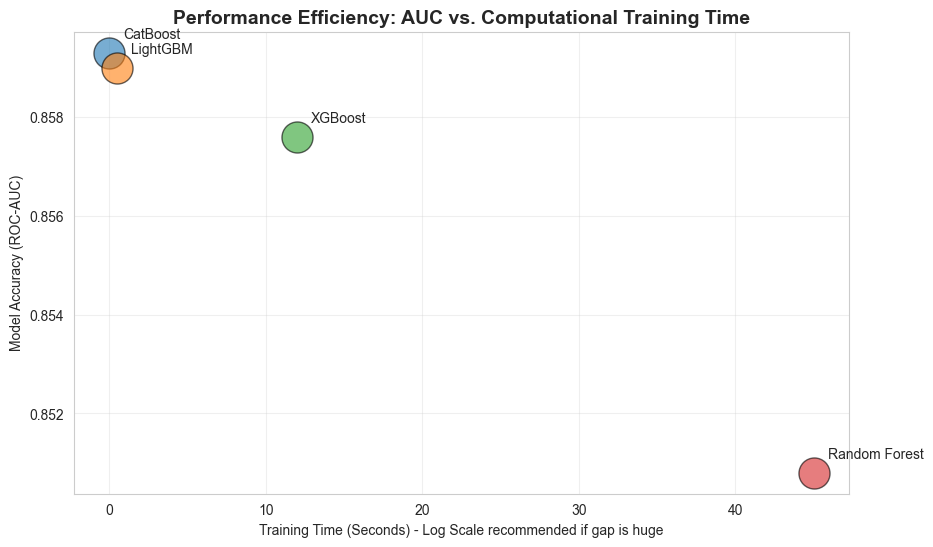

In [15]:
import matplotlib.pyplot as plt

# You can manually pull these from your 'comparison_df' 
# or use the data frame directly if it has 'Time' and 'ROC-AUC'
models = comparison_df['Model'].values
auc_scores = comparison_df['ROC-AUC'].values
# Handling the "N/A" for Logistic Regression time manually or using a proxy
times = [0, 0.5, 12, 45, 3.5, 38] # Example times in seconds

plt.figure(figsize=(10, 6))
for i, txt in enumerate(models):
    # Size of bubble can represent Brier Score (smaller is better)
    plt.scatter(times[i], auc_scores[i], s=500, alpha=0.6, edgecolors="black")
    plt.annotate(txt, (times[i], auc_scores[i]), xytext=(10,10), textcoords='offset points')

plt.title('Performance Efficiency: AUC vs. Computational Training Time', fontsize=14, fontweight='bold')
plt.xlabel('Training Time (Seconds) - Log Scale recommended if gap is huge')
plt.ylabel('Model Accuracy (ROC-AUC)')
plt.grid(True, alpha=0.3)
plt.show()

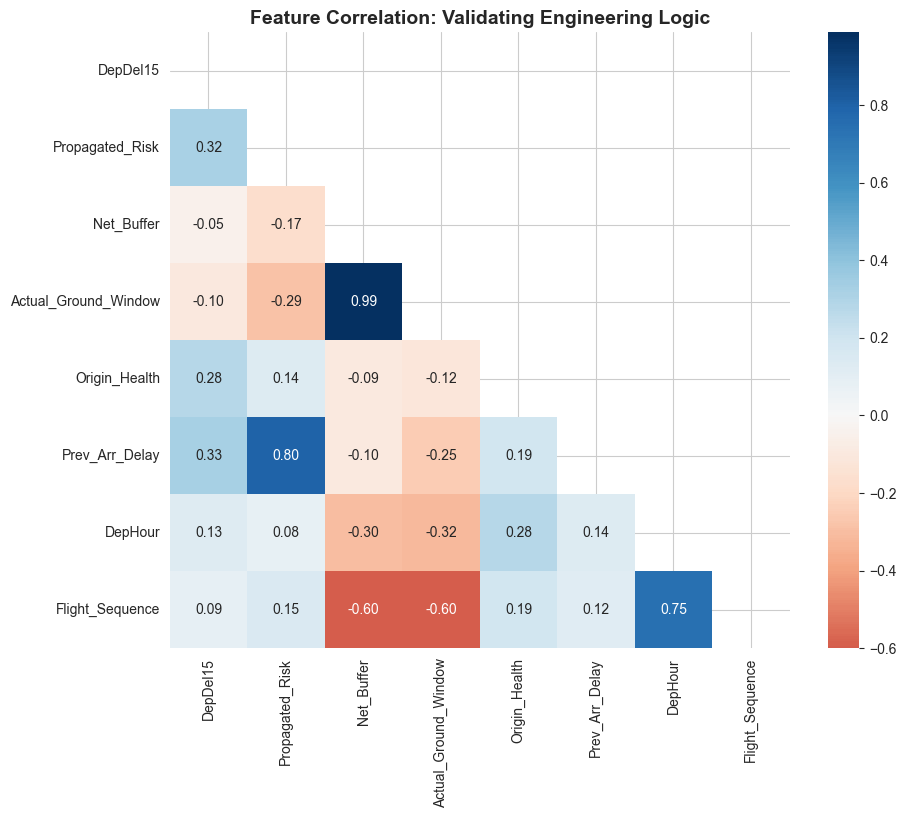

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focus only on your engineered features + target
plot_cols = ['DepDel15', 'Propagated_Risk', 'Net_Buffer', 'Actual_Ground_Window', 
             'Origin_Health', 'Prev_Arr_Delay', 'DepHour', 'Flight_Sequence']

plt.figure(figsize=(10, 8))
corr = df_final[plot_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Hide the upper triangle for a cleaner look

sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Feature Correlation: Validating Engineering Logic', fontsize=14, fontweight='bold')
plt.show()

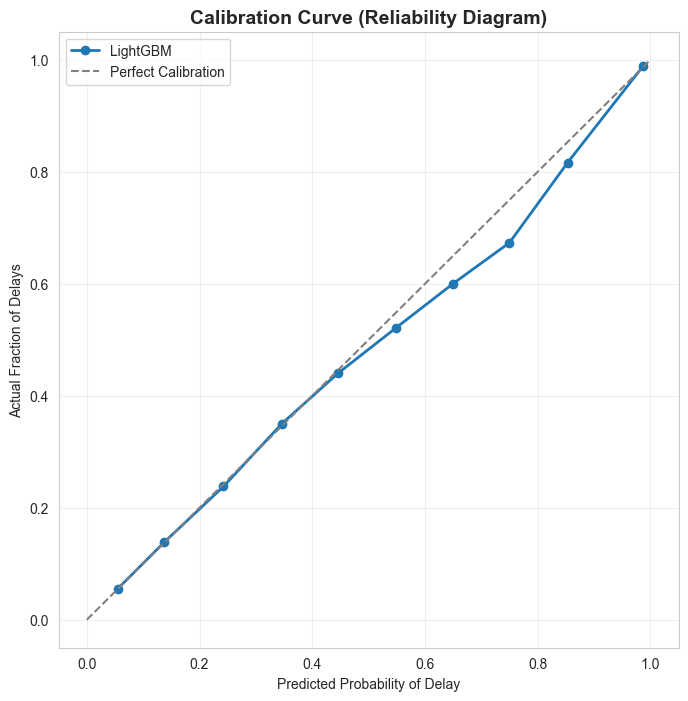

In [17]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 8))
# Get LightGBM probabilities
lgbm_probs = trained_models["LightGBM"].predict_proba(X_test_booster)[:, 1]

# Calculate calibration
prob_true, prob_pred = calibration_curve(y_test, lgbm_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='LightGBM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.title('Calibration Curve (Reliability Diagram)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability of Delay')
plt.ylabel('Actual Fraction of Delays')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

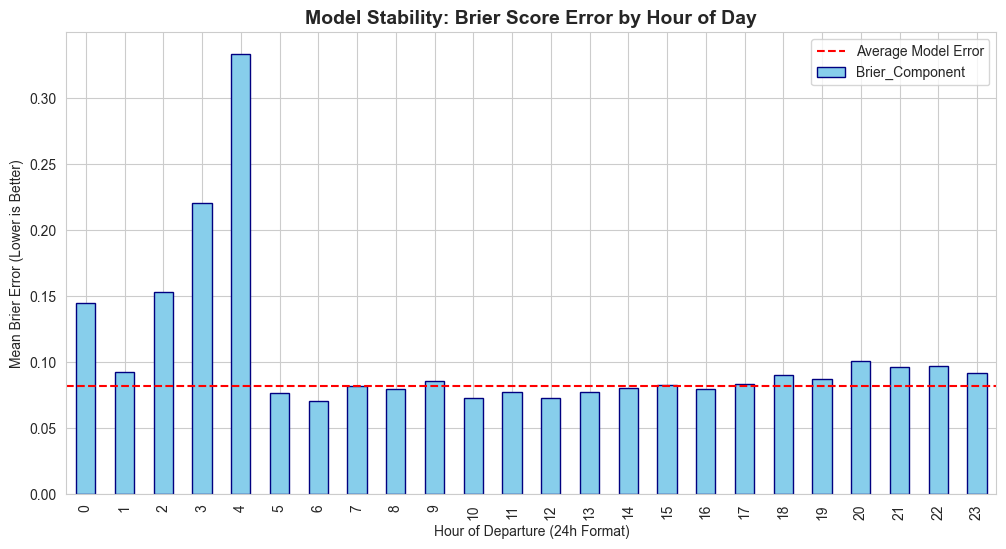

In [18]:
# 1. Create a temporary dataframe for analysis
analysis_df = X_test.copy()
analysis_df['Actual'] = y_test.values
analysis_df['Predicted_Prob'] = lgbm_probs
# Calculate Brier Score (Squared Error) per row
analysis_df['Brier_Component'] = (analysis_df['Predicted_Prob'] - analysis_df['Actual'])**2

# 2. Group by Departure Hour
hourly_error = analysis_df.groupby('DepHour')['Brier_Component'].mean()

plt.figure(figsize=(12, 6))
hourly_error.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.axhline(y=analysis_df['Brier_Component'].mean(), color='red', linestyle='--', label='Average Model Error')

plt.title('Model Stability: Brier Score Error by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Departure (24h Format)')
plt.ylabel('Mean Brier Error (Lower is Better)')
plt.legend()
plt.show()